In [1]:
import pandas as pd
import numpy as np
import mikeio
import matplotlib.pyplot as plt
from random import random

## Test data

Model results

model result equidistant at lower res than observations, with nan and with gap

In [2]:
fn = '../tests/testdata/SW/ts_storm_4.dfs0'
mr1 = mikeio.read(fn, items=0).to_dataframe()
mr1 = mr1.resample('2H').nearest()
mr1 = mr1.rename(columns={mr1.columns[0]:'mr1'})
mr2 = mr1.copy().rename(columns=dict(mr1='mr2'))-1 # for plotting...
mr2.loc["2017-10-28"] = np.nan
mr3 = mr2.copy().dropna().rename(columns=dict(mr2='mr3'))-1

Observation

With random time steps and with gaps

In [3]:
fn = '../tests/testdata/SW/eur_Hm0.dfs0'
obs = mikeio.read(fn, items=0).to_dataframe().rename(columns=dict(Hm0='obs'))+1
dt = pd.Timedelta(1800, unit='s')
obs.index = [t+dt*(random()-0.5) for t in obs.index]
obs.index = obs.index.round('S')
obs = obs.sample(frac=0.7).sort_index()

Plot test data

Text(0.5, 1.0, 'Test data')

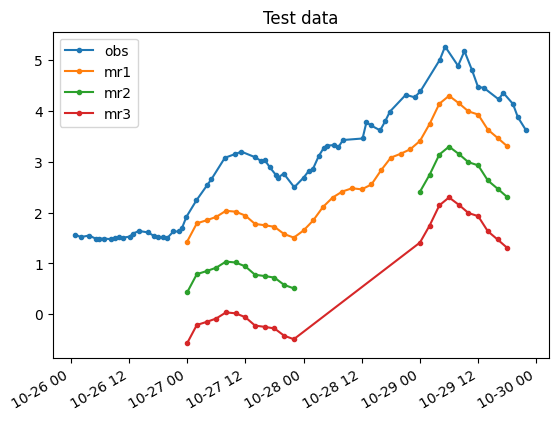

In [4]:
fig, ax = plt.subplots(1,1)
obs.plot(ax=ax, marker='.')
mr1.plot(ax=ax, marker='.')
mr2.plot(ax=ax, marker='.')
mr3.plot(ax=ax, marker='.')
plt.title('Test data')

## v1: no model gap handling

modelskill previous to max model gap fix

--> Not doing the job as we know

In [5]:
def interp_df(df, new_time):
    new_df = (
        df.reindex(df.index.union(new_time))
        .interpolate(method="time", limit_area="inside")
        .reindex(new_time)
        )
    return new_df

In [6]:
c = (
    obs.join(interp_df(mr1, obs.index))
    .join(interp_df(mr2, obs.index))
    .join(interp_df(mr3, obs.index))
)
c.loc["2017-10-28"].head(2)

,obs,mr1,mr2,mr3
2017-10-28 00:00:53,2.69,1.650797,0.656920,-0.343080
2017-10-28 01:04:38,2.82,1.756433,0.734647,-0.265353


<AxesSubplot: title={'center': 'No model gap handling'}>

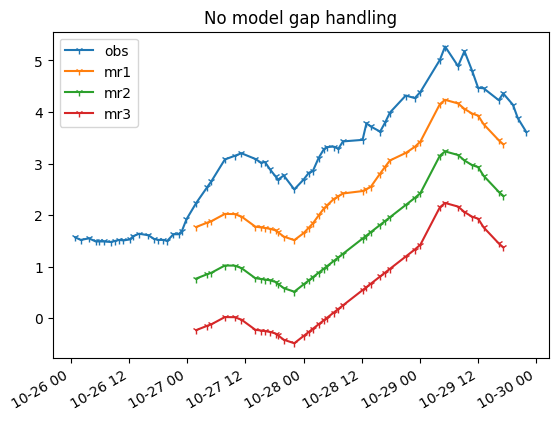

In [7]:
c.plot(marker='1', title='No model gap handling')

In [8]:
c.count()

obs    66
mr1    41
mr2    41
mr3    41
dtype: int64

### v2: pandas interpolation limit

Current suggestion with limit, probably sufficient for most use cases. 

--> But how to robust choose an int limit for a non-equidistant query time vector of the obs?

In [9]:
import statistics as stats
def mode_of_timestep(time):
    return pd.Timedelta(stats.mode(np.diff(time)))

In [10]:
def get_limit(time, max_timedelta):
    return int(np.ceil(max_timedelta/mode_of_timestep(time))) # not very robust...?

In [11]:
def interp_df_v2(df, new_time, max_model_gap):
    limit = get_limit(new_time, max_model_gap)
    new_df = (
        df.reindex(df.index.union(new_time))
        .interpolate(method="time", limit_area="inside", limit=limit)
        .reindex(new_time)
        )
    return new_df

Max model gap as mode of time step (could be default...?)

In [12]:
max_model_gap1 = mode_of_timestep(mr1.index)
max_model_gap2 = mode_of_timestep(mr2.index)
max_model_gap3 = mode_of_timestep(mr3.index)
max_model_gap1, max_model_gap2, max_model_gap3

(Timedelta('0 days 02:00:00'),
 Timedelta('0 days 02:00:00'),
 Timedelta('0 days 02:00:00'))

In [13]:
c2 = (
    obs.join(interp_df_v2(mr1, obs.index, max_model_gap1))
    .join(interp_df_v2(mr2, obs.index, max_model_gap2))
    .join(interp_df_v2(mr3, obs.index, max_model_gap3))
)
c2.loc["2017-10-28"].head()

,obs,mr1,mr2,mr3
2017-10-28 00:00:53,2.69,1.650797,NaN,-0.34308
2017-10-28 01:04:38,2.82,1.756433,NaN,NaN
2017-10-28 01:56:25,2.86,NaN,NaN,NaN
2017-10-28 03:06:54,3.11,1.994866,NaN,NaN
2017-10-28 04:11:59,3.28,2.129899,NaN,NaN


mr3 with the actual gap is handled differently than mr2 with nan, although both have the same max gap.

In [14]:
c2.count()

obs    66
mr1    38
mr2    23
mr3    24
dtype: int64

<AxesSubplot: >

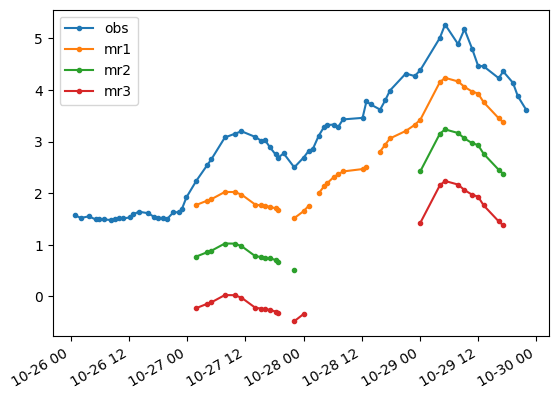

In [15]:
c2.plot(marker='.')

### v3: Manually identify valid obs timesteps to query

Identify the valid query times, which are surrounded by source (model) times less than max_gap appart.

Can be shortened...

In [16]:
def get_valid_query_time(df, query_time, max_gap):
    source_time = df.dropna().index

    # init dataframe of available timesteps and their index
    df = pd.DataFrame(index=source_time)
    df['idx'] = range(len(df))

    # for query times get available left and right index of source times
    df = interp_df(df, query_time).dropna()
    df['idxa'] = np.floor(df.idx).astype(int)
    df['idxb'] = np.ceil(df.idx).astype(int)

    # time of left and right source times and time delta
    df['ta'] = source_time[df.idxa]
    df['tb'] = source_time[df.idxb]
    df['dt'] = df.tb-df.ta

    # valid query times where time delta is less than max_gap
    valid_time = df.index[df.dt<=max_gap]

    return valid_time

In [17]:
def interp_df_v3(df, new_time, max_model_gap):
    valid_time = get_valid_query_time(df, new_time, max_model_gap)
    new_df = (
        df.reindex(df.index.union(valid_time))
        .interpolate(method="time", limit_area="inside")
        .reindex(valid_time)
        )
    return new_df

In [18]:
c3 = (
    obs.join(interp_df_v3(mr1, obs.index, max_model_gap1))
    .join(interp_df_v3(mr2, obs.index, max_model_gap2))
    .join(interp_df_v3(mr3, obs.index, max_model_gap3))
)
c3.loc["2017-10-28"].head()

,obs,mr1,mr2,mr3
2017-10-28 00:00:53,2.69,1.650797,NaN,NaN
2017-10-28 01:04:38,2.82,1.756433,NaN,NaN
2017-10-28 01:56:25,2.86,1.842241,NaN,NaN
2017-10-28 03:06:54,3.11,1.994866,NaN,NaN
2017-10-28 04:11:59,3.28,2.129899,NaN,NaN


Not loosing any model data points of mr1 and getting same number of points for mr2 and mr3:

In [19]:
c3.count()

obs    66
mr1    41
mr2    23
mr3    23
dtype: int64

<AxesSubplot: >

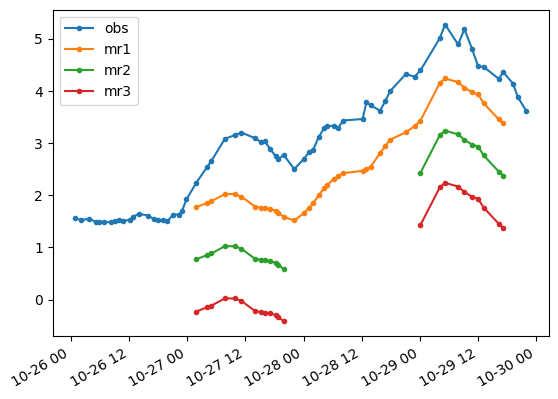

In [20]:
c3.plot(marker='.')

## Misc

Btw, in this format observations can easily be maintained only where *all* models are available (to ensure the fair multi-model comparison).

<AxesSubplot: >

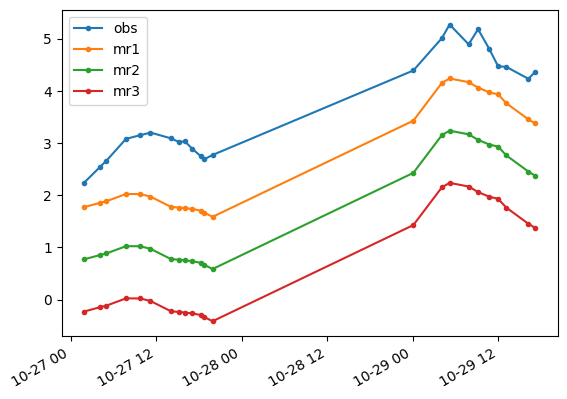

In [21]:
c3.dropna().plot(marker='.')